In [798]:
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.core.display import clear_output
from IPython.display import Image  
from math import sqrt
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pprint import pprint
from pylab import rcParams
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statistics import mean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from subprocess import call
from termcolor import colored
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

## Data load

In [799]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
df = pd.read_csv(url,index_col=0)
df.head(5)

,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [800]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 17526 entries, 2020-01-22 to 2020-03-30
Data columns (total 7 columns):
Country/Region    17526 non-null object
Province/State    5451 non-null object
Lat               17526 non-null float64
Long              17526 non-null float64
Confirmed         17457 non-null float64
Recovered         16560 non-null float64
Deaths            17457 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.1+ MB


In [801]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(17526, 7)

In [802]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [803]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [804]:
df.head()

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global
Date,,,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,1
2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,2
2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,3
2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,4
2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,5


In [805]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [806]:
len(df['Province_and_country'].unique())

254

In [807]:
len(df['Country'].unique())

178

In [808]:
len(df['Province'].unique())

80

In [809]:
df.describe()

,Lat,Long,Confirmed,Recovered,Deaths,Days_since_outbreak_global
count,17526.000000,17526.000000,17457.000000,16560.000000,17457.000000,17526.000000
mean,22.196742,22.851084,558.336942,175.706099,22.448874,35.000000
std,24.521309,71.674380,5090.761047,2354.812872,289.163767,19.917061
min,-41.454500,-135.000000,0.000000,0.000000,0.000000,1.000000
25%,8.538000,-23.041800,0.000000,0.000000,0.000000,18.000000
50%,23.914900,20.921188,0.000000,0.000000,0.000000,35.000000
75%,41.377500,85.240100,31.000000,1.000000,0.000000,52.000000
max,71.706900,178.065000,161807.000000,62889.000000,11591.000000,69.000000


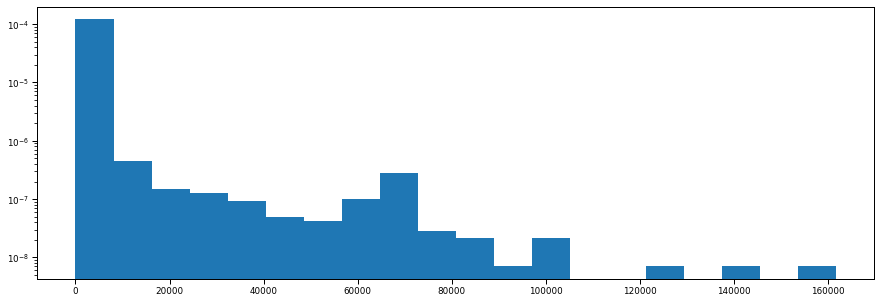

In [810]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

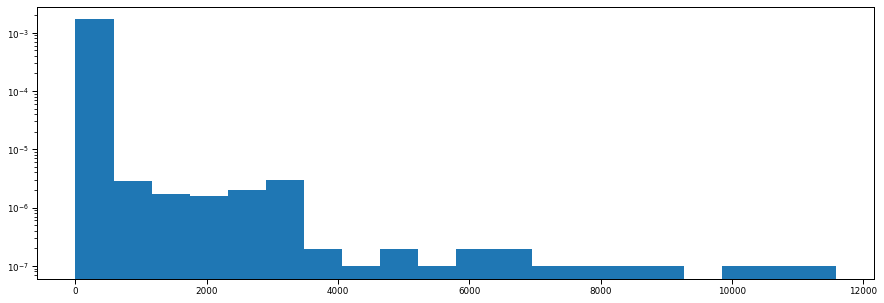

In [811]:
plt.hist(df['Deaths'], density=True, bins=20) 
plt.yscale('log')

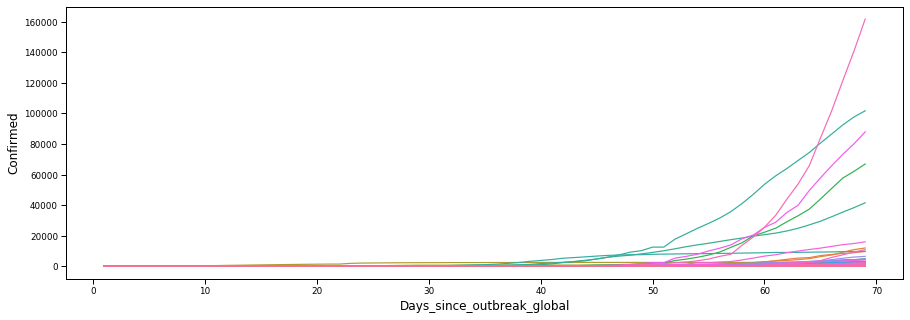

In [812]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

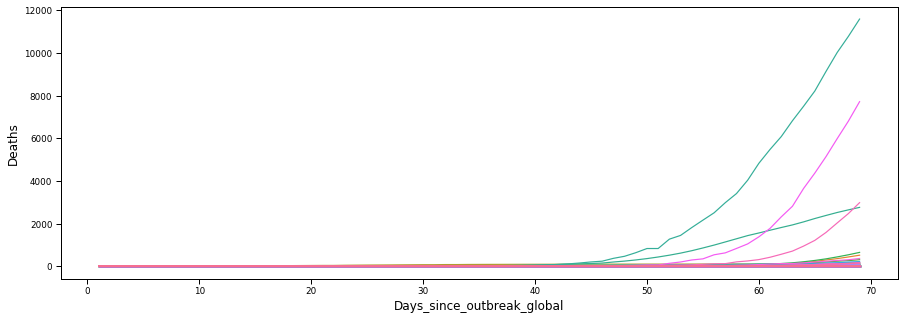

In [813]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Deaths", ci=None)
ax.legend_.remove()

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...     60     61     62     63     64     65  \
Country                     ...                                             
Afghanistan                 ...   24.0   40.0   40.0   74.0   84.0   94.0   
Albania                     ...   76.0   89.0  104.0  123.0  146.0  174.0   
Algeria                     ...  139.0  201.0  230.0  264.0  302.0  367.0   
Andorra                     ...   88.0  113.0  133.0  

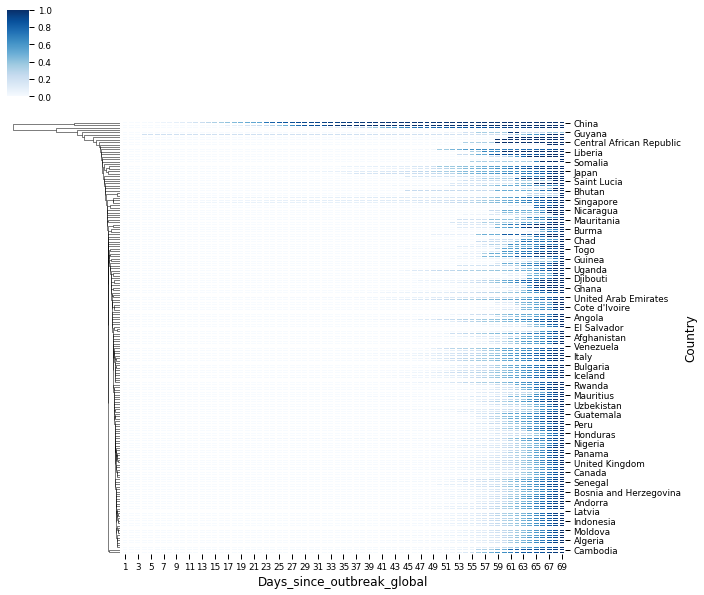

<Figure size 1800x576 with 0 Axes>

In [814]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [815]:
# function for getting the iso code through fuzzy search
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_2

# manually change name of some countries
df.loc[df['Country'] == 'Korea, South', 'Country'] = 'Korea, Republic of'
df.loc[df['Country'] == 'Taiwan*', 'Country'] = 'Taiwan'
df.loc[df['Country'] == 'Burma', 'Country'] = 'Myanmar'
df.loc[df['Country'] == 'Holy See', 'Country'] = 'Italy'
df.loc[df['Country'] == 'Laos', 'Country'] = "Lao"
df.loc[df['Country'] == "Congo (Kinshasa)", 'Country'] = "Congo"
df.loc[df['Country'] == "Congo (Brazzaville)", 'Country'] = "Congo"
df.loc[df['Country'] == "West Bank and Gaza", 'Country'] = "Palestine"

# create iso mapping for countries in df
iso_map = {country: do_fuzzy_search(country) for country in df['Country'].unique()}
# apply the mapping to df
df['iso'] = df['Country'].map(iso_map)

In [816]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Congo", 'Continent'] = "AF"
df.loc[df['Country'] == 'Timor-Leste', 'Continent'] = 'AS'
df.loc[df['Country'] == 'Diamond Princess', 'Continent'] = 'Diamond Princess'

df['Continent'] = df['Continent'].map({'Diamond Princess':'Diamond Princess','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global     1      2      3       4       5       6   \
Continent                                                                 
Africa                        0.0    0.0    0.0     0.0     0.0     0.0   
Asia                        554.0  653.0  937.0  1429.0  2105.0  2912.0   
Diamond Princess              0.0    0.0    0.0     0.0     0.0     0.0   
Europe                        0.0    0.0    2.0     3.0     3.0     4.0   
North America                 1.0    1.0    2.0     2.0     6.0     6.0   

Days_since_outbreak_global      7       8       9       10  ...        60  \
Continent                                                   ...             
Africa                         0.0     0.0     0.0     0.0  ...    1172.0   
Asia                        5558.0  6143.0  8208.0  9889.0  ...  120030.0   
Diamond Princess               0.0     0.0     0.0     0.0  ...     712.0   
Europe                         8.0    10.0    10.0    18.0  ...  150847.0   
North Americ

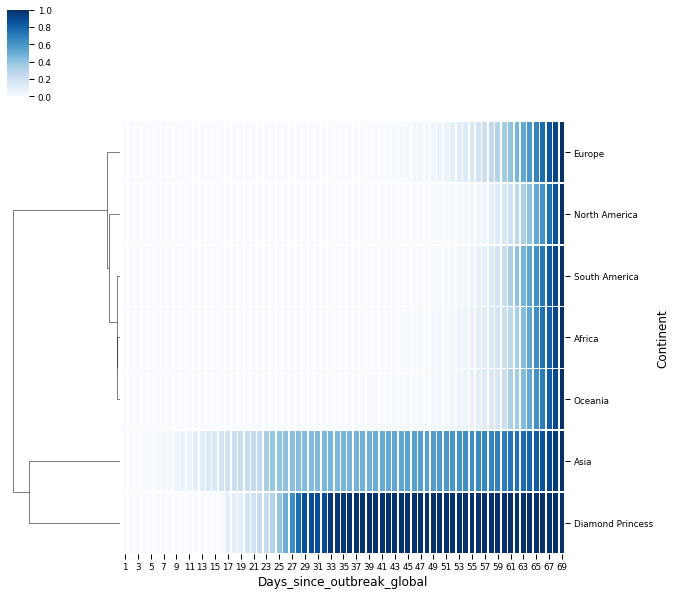

<Figure size 1800x576 with 0 Axes>

In [817]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Armenia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Azerbaijan                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahrain                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bangladesh                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...     60     61     62     63     64     65  \
Country                     ...                                             
Afghanistan                 ...   24.0   40.0   40.0   74.0   84.0   94.0   
Armenia                     ...  160.0  194.0  235.0  249.0  265.0  290.0   
Azerbaijan                  ...   53.0   65.0   72.0   87.0   93.0  122.0   
Bahrain                     ...  305.0  334.0  377.0  

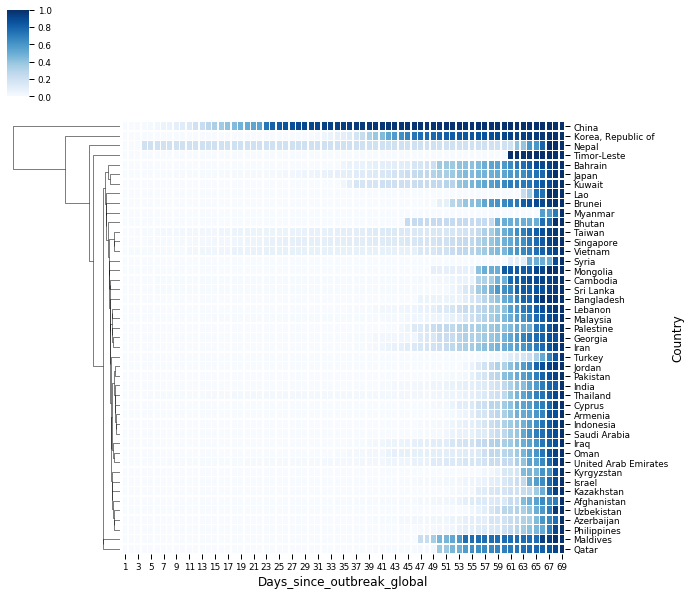

<Figure size 1800x576 with 0 Axes>

In [818]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Austria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belarus                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belgium                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...      60      61      62      63      64  \
Country                     ...                                           
Albania                     ...    76.0    89.0   104.0   123.0   146.0   
Andorra                     ...    88.0   113.0   133.0   164.0   188.0   
Austria                     ...  2814.0  3582.0  4474.0  5283.0  5588.0   
Belarus                     ...    76.0    76.0    81.0    81.0 

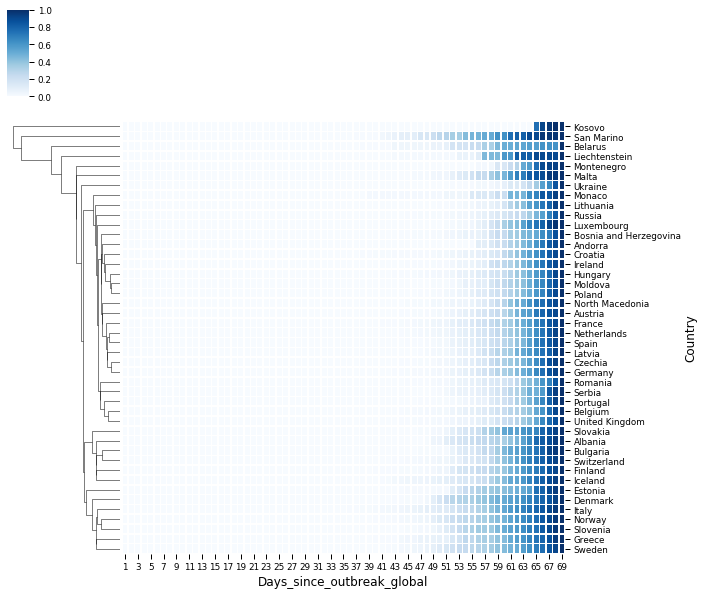

<Figure size 1800x576 with 0 Axes>

In [819]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Benin                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Botswana                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Burkina Faso                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...     60     61     62     63     64     65  \
Country                     ...                                             
Algeria                     ...  139.0  201.0  230.0  264.0  302.0  367.0   
Angola                      ...    2.0    2.0    3.0    3.0    3.0    4.0   
Benin                       ...    2.0    2.0    5.0    6.0    6.0    6.0   
Botswana                    ...    0.0    0.0    0.0  

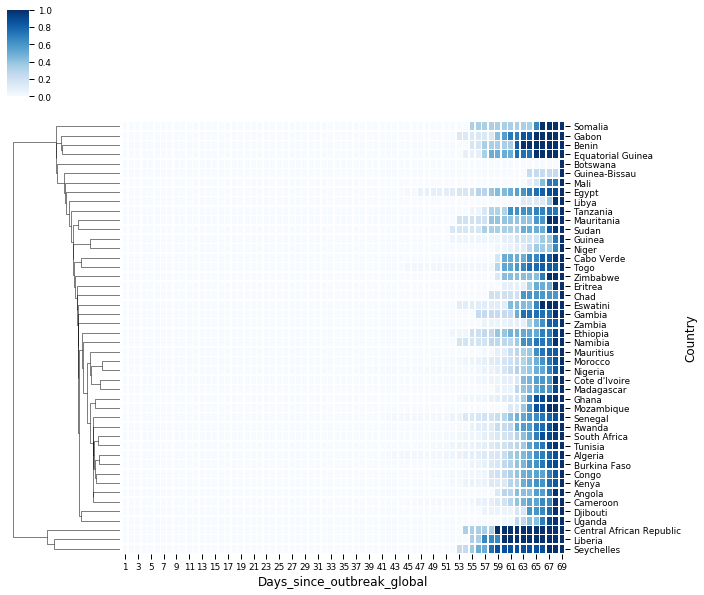

<Figure size 1800x576 with 0 Axes>

In [820]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahamas                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Barbados                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belize                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Canada                      0.0  0.0  0.0  0.0  1.0  1.0  2.0  2.0  2.0  4.0   

Days_since_outbreak_global  ...      60      61      62      63      64  \
Country                     ...                                           
Antigua and Barbuda         ...     1.0     1.0     3.0     3.0     3.0   
Bahamas                     ...     4.0     4.0     4.0     5.0     5.0   
Barbados                    ...     6.0    14.0    17.0    18.0    18.0   
Belize                      ...     0.0     0.0     1.0     1.0 

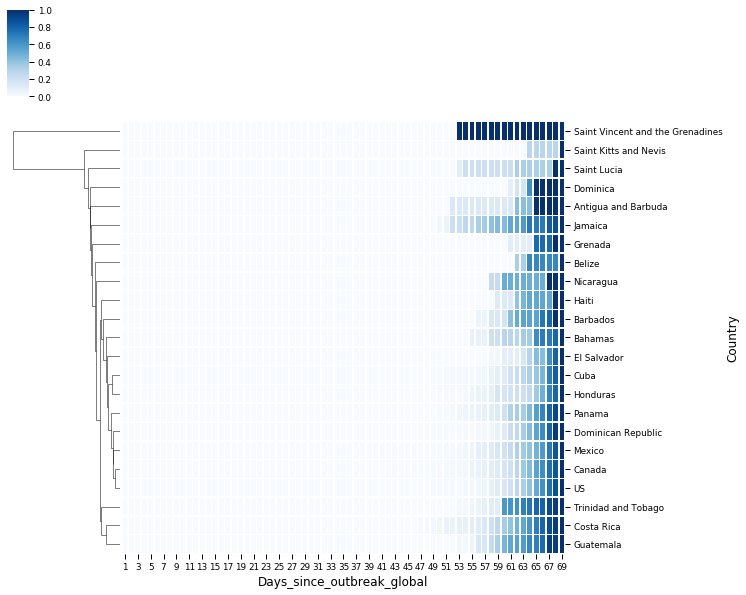

<Figure size 1800x576 with 0 Axes>

In [821]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Australia                   0.0  0.0  0.0  0.0  4.0  5.0  5.0  6.0  9.0  9.0   
Fiji                        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
New Zealand                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Papua New Guinea            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...      60      61      62      63      64  \
Country                     ...                                           
Australia                   ...  1071.0  1549.0  1682.0  2044.0  2364.0   
Fiji                        ...     1.0     2.0     3.0     4.0     5.0   
New Zealand                 ...    52.0   102.0   102.0   155.0   205.0   
Papua New Guinea            ...     1.0     1.0     1.0     1.0     1.0   

Days_since_outbreak_global      65      66      67      68      69  

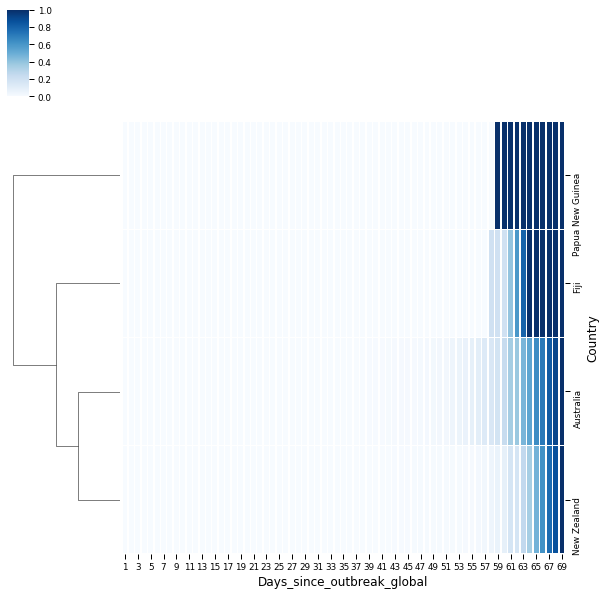

<Figure size 1800x576 with 0 Axes>

In [822]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bolivia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Brazil                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Chile                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Colombia                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...      60      61      62      63      64  \
Country                     ...                                           
Argentina                   ...   158.0   266.0   301.0   387.0   387.0   
Bolivia                     ...    19.0    24.0    27.0    29.0    32.0   
Brazil                      ...  1021.0  1546.0  1924.0  2247.0  2554.0   
Chile                       ...   537.0   632.0   746.0   922.0 

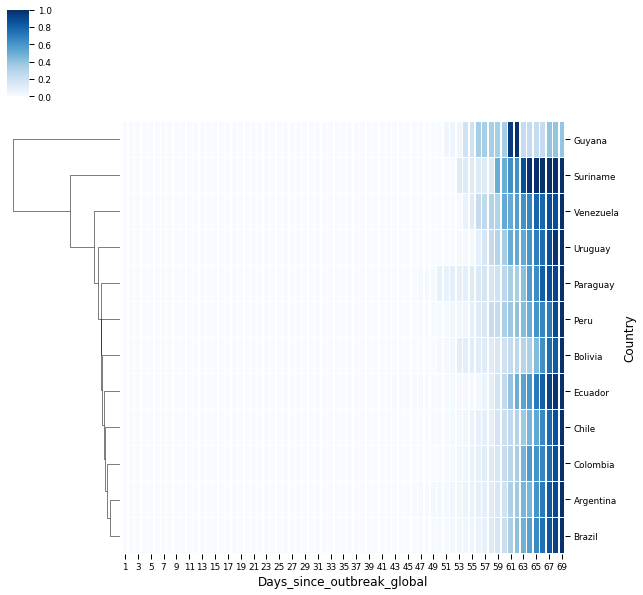

<Figure size 1800x576 with 0 Axes>

In [823]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [824]:
df['Date'] = df.index
df = df.reset_index(drop = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = (df['Confirmed']/df['Confirmed_lag_1'])-1
df['Deaths_lag_1'] = df.groupby('Province_and_country')['Deaths'].shift(1)
df['Daily_increase_death'] = (df['Deaths']/df['Deaths_lag_1'])-1
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global,iso,...,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed,Deaths_lag_1,Daily_increase_death
0,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,1,AF,...,22,2,4,1,1,2020,0.0,0.000000,0.0,0.0
1,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,2,AF,...,23,3,4,1,1,2020,0.0,0.000000,0.0,0.0
2,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,3,AF,...,24,4,4,1,1,2020,0.0,0.000000,0.0,0.0
3,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,4,AF,...,25,5,4,1,1,2020,0.0,0.000000,0.0,0.0
4,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,5,AF,...,26,6,4,1,1,2020,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17521,Zimbabwe,0,-20.0,30.0,3.0,0.0,1.0,Zimbabwe,65,ZW,...,26,3,13,1,3,2020,3.0,0.000000,1.0,0.0
17522,Zimbabwe,0,-20.0,30.0,5.0,0.0,1.0,Zimbabwe,66,ZW,...,27,4,13,1,3,2020,3.0,0.666667,1.0,0.0
17523,Zimbabwe,0,-20.0,30.0,7.0,0.0,1.0,Zimbabwe,67,ZW,...,28,5,13,1,3,2020,5.0,0.400000,1.0,0.0
17524,Zimbabwe,0,-20.0,30.0,7.0,0.0,1.0,Zimbabwe,68,ZW,...,29,6,13,1,3,2020,7.0,0.000000,1.0,0.0


In [825]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        60        61        62        63  \
Country                     ...                                           
Afghanistan                 ...  0.000000  0.666667  0.000000  0.850000   
Albania                     ...  0.085714  0.171053  0.168539  0.182692   
Algeria                     ...  0.544444  0.446043  0.144279  0.147826   
Andorra                     ...  0.173333  0.284091  0.176991  0

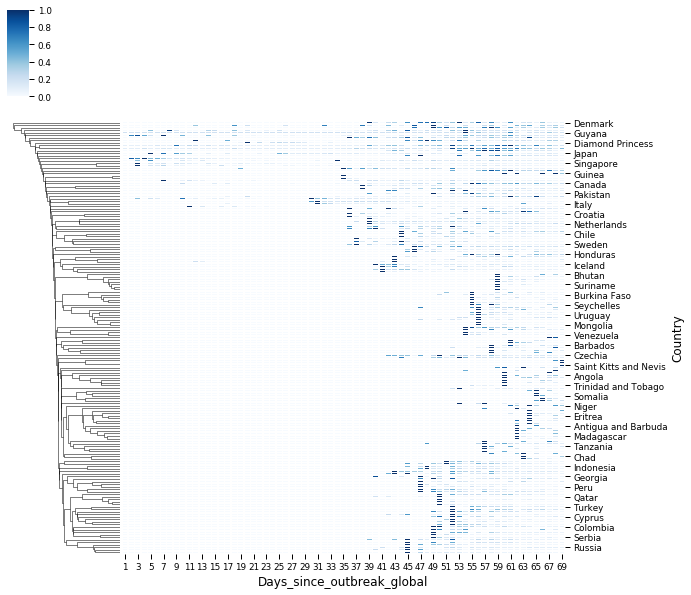

<Figure size 1800x576 with 0 Axes>

In [826]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1          2          3          4          5   \
Continent                                                                     
Africa                      0.0   0.000000   0.000000   0.000000   0.000000   
Asia                        0.0  32.879976  31.618121  39.505271  19.947801   
Diamond Princess            0.0   0.000000   0.000000   0.000000   0.000000   
Europe                      0.0   0.000000   0.000000   0.500000   0.000000   
North America               0.0   0.000000   1.000000   0.000000   1.500000   

Days_since_outbreak_global         6          7         8         9   \
Continent                                                              
Africa                       0.000000   0.000000  0.000000  0.000000   
Asia                        20.027021  15.679485  7.478922  9.050445   
Diamond Princess             0.000000   0.000000  0.000000  0.000000   
Europe                       0.000000   3.333333  0.250000  0.000000   
North America 

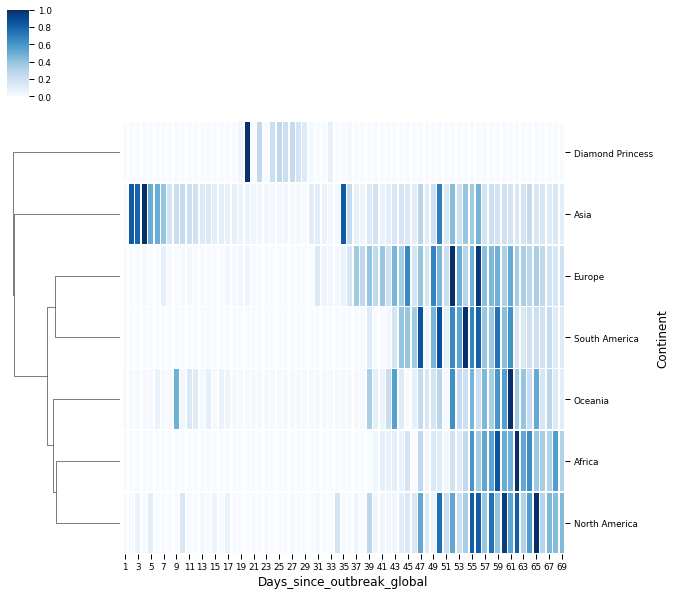

<Figure size 1800x576 with 0 Axes>

In [827]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Armenia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Azerbaijan                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahrain                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bangladesh                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        60        61        62        63  \
Country                     ...                                           
Afghanistan                 ...  0.000000  0.666667  0.000000  0.850000   
Armenia                     ...  0.176471  0.212500  0.211340  0.059574   
Azerbaijan                  ...  0.204545  0.226415  0.107692  0.208333   
Bahrain                     ...  0.070175  0.095082  0.128743  0

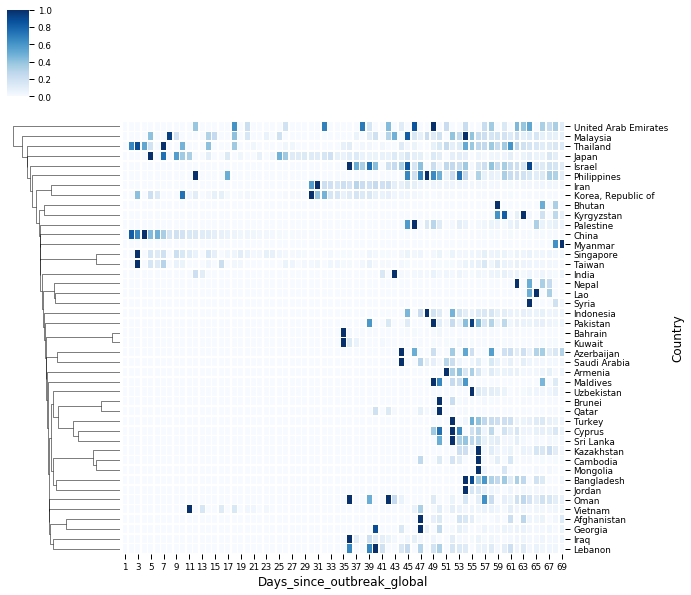

<Figure size 1800x576 with 0 Axes>

In [828]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Austria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belarus                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belgium                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        60        61        62        63  \
Country                     ...                                           
Albania                     ...  0.085714  0.171053  0.168539  0.182692   
Andorra                     ...  0.173333  0.284091  0.176991  0.233083   
Austria                     ...  0.178392  0.272921  0.249023  0.180823   
Belarus                     ...  0.101449  0.000000  0.065789  0

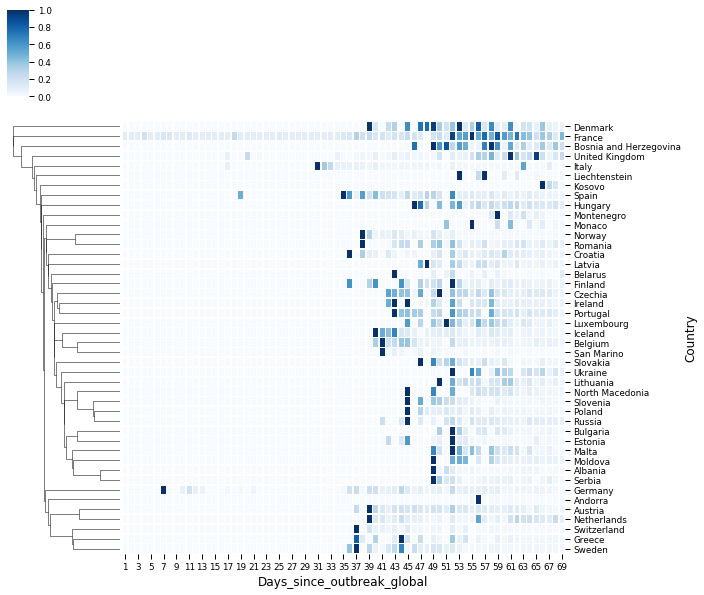

<Figure size 1800x576 with 0 Axes>

In [829]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Benin                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Burkina Faso                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Cabo Verde                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        60        61        62        63  \
Country                     ...                                           
Algeria                     ...  0.544444  0.446043  0.144279  0.147826   
Angola                      ...  1.000000  0.000000  0.500000  0.000000   
Benin                       ...  0.000000  0.000000  1.500000  0.200000   
Burkina Faso                ...  0.600000  0.171875  0.320000  0

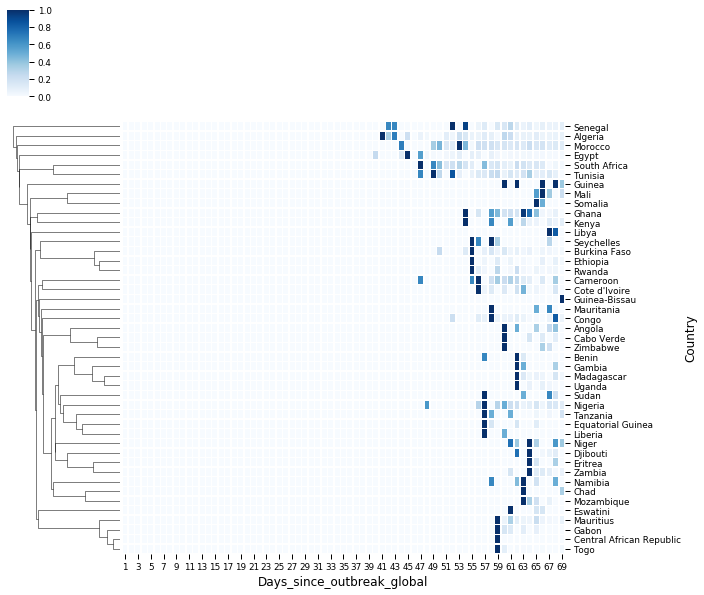

<Figure size 1800x576 with 0 Axes>

In [830]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahamas                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Barbados                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belize                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Canada                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   

Days_since_outbreak_global  ...        60        61        62        63  \
Country                     ...                                           
Antigua and Barbuda         ...  0.000000  0.000000  2.000000  0.000000   
Bahamas                     ...  0.333333  0.000000  0.000000  0.250000   
Barbados                    ...  0.200000  1.333333  0.214286  0.058824   
Belize                      ...  0.000000  0.000000  0.000000  0

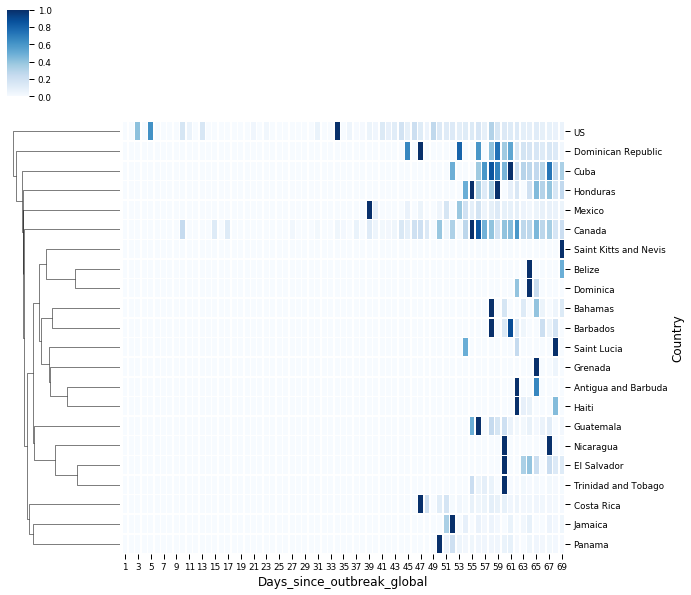

<Figure size 1800x576 with 0 Axes>

In [831]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5         6    7    8    9   \
Country                                                                        
Australia                   0.0  0.0  0.0  0.0  0.0  0.333333  0.0  0.0  3.0   
Fiji                        0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
New Zealand                 0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   

Days_since_outbreak_global        10  ...        60        61        62  \
Country                               ...                                 
Australia                   0.166667  ...  3.175026  4.235216  1.695265   
Fiji                        0.000000  ...  0.000000  1.000000  0.500000   
New Zealand                 0.000000  ...  0.333333  0.961538  0.000000   

Days_since_outbreak_global        63        64        65        66        67  \
Country                                                                        
Australia                   1.562388  0.793349  2.780275  0.645

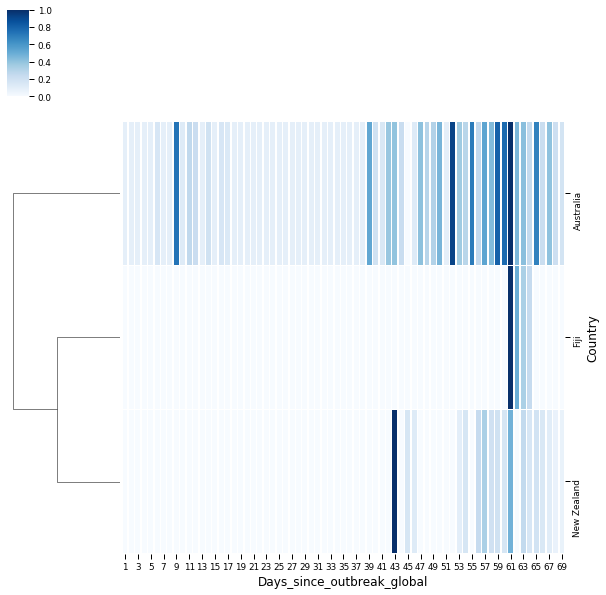

<Figure size 1800x576 with 0 Axes>

In [832]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bolivia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Brazil                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Chile                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Colombia                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        60        61        62        63  \
Country                     ...                                           
Argentina                   ...  0.234375  0.683544  0.131579  0.285714   
Bolivia                     ...  0.266667  0.263158  0.125000  0.074074   
Brazil                      ...  0.287516  0.514202  0.244502  0.167879   
Chile                       ...  0.237327  0.176909  0.180380  0

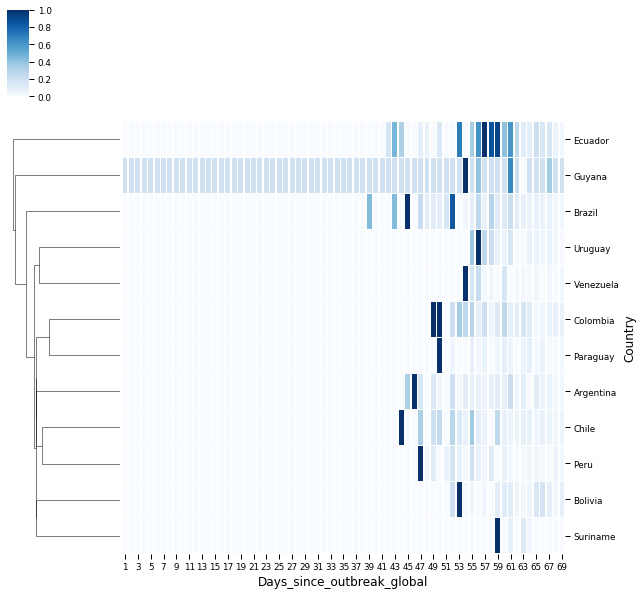

<Figure size 1800x576 with 0 Axes>

In [833]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction - preperation

In [834]:
#Confirmed
df_ml_confirmed = df
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]

In [835]:
df_ml.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [841]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 3, 23, 21, 41, 55, 264595)

In [842]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

31847.581003329968
178.45890564309187
2.694589897760057
-0.5905399769645621


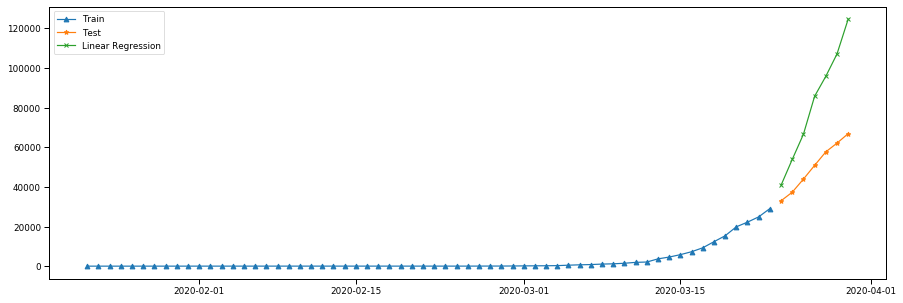

In [843]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(mean((Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']))

6715.984692406718
81.9511115995794
0.568232309505018
0.1176306794932028


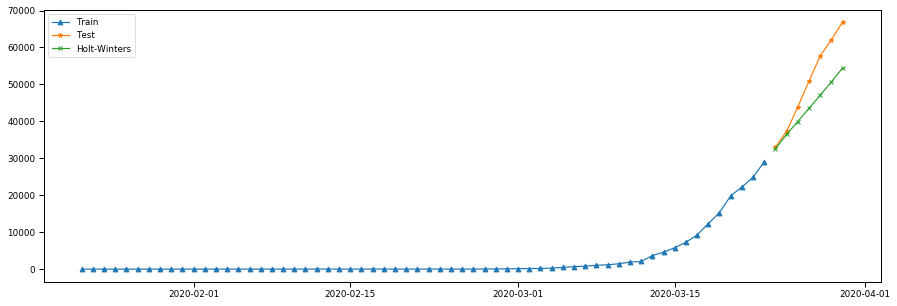

In [844]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))
print(mean((test.Confirmed - pred.Confirmed) / test.Confirmed))

In [874]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [900]:
edf = List['Confirmed']
ts = edf[:split_date].copy()
ts_v = edf[split_date:].copy()
ind = edf.index[-7:]  

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:split_date].copy()
        test = edf[split_date:split_date+timedelta(days=7)].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(7)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
2.709792642851857
3
['add', True, 'add', 6, False, False]
2.73033527802856
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
2.704308648858852
11
['add', True, None, 6, False, False]
2.7255405754769875
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
1.4431209510676293
15
['add', False, 'add', 6, False, False]
1.4589280113997531
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, Fals

In [901]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [902]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(7)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

1.4431209510676293 ['add', False, 'add', 6, False, True]
Mean Absolute Error: 1.243
Mean Squared Error: 5.332
Root Mean Squared Error: 1.443
Mean absolute percentage error: 23.593
Scaled Mean absolute percentage error: 24.864
Mean forecast error: 4.368
Normalised mean squared error: 0.521
Theil_u_statistic: 0.062
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


7061.435661659577
84.03234890004906
0.5974605479644113
0.12429987661048829


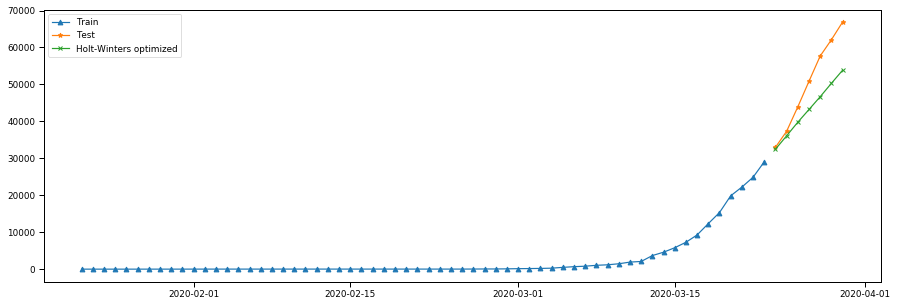

In [904]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=6, damped=False) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))
print(mean((test.Confirmed - pred.Confirmed) / test.Confirmed))

#['add', False, 'add', 6, False, True]
# t1,d1,s1,p1,b1,r1

7244.795835855591
85.11636643945505
0.612974456948219
0.1294943394122909


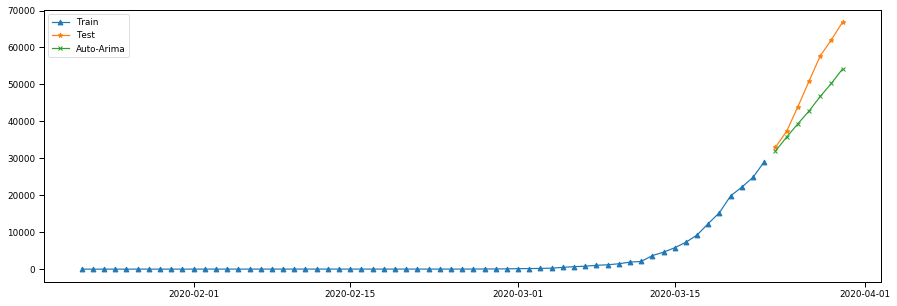

In [853]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))
print(mean((test.Confirmed - pred.Confirmed) / test.Confirmed))

### All customers

In [923]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [924]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [925]:
Train_and_Test = Train_and_Test.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test.loc[Train_and_Test.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test.loc[Train_and_Test.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test.loc[Train_and_Test.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test.loc[Train_and_Test.MPE.notnull(), 'MPE']))

1218.3813064082285
14.788035412675077
5.095861023997667
-0.3471448377068324


#### Holt-Winters (non-optimized)

In [926]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test.append(Train_and_Test_Holt)


Finished!


,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country,Confirmed_Prediction,Model,MPE,MAE,RMSE,SDMAE
Date,,,,,,,,,,,,,,,,,,
2020-03-24,74.0,Afghanistan,63,2020-03-24,24,1,13,1,3,2020,22.0,63,49.085754,Linear Regression,0.336679,48.054705,6.932150,1.652593
2020-03-25,84.0,Afghanistan,64,2020-03-25,25,2,13,1,3,2020,22.0,64,49.291766,Linear Regression,0.413193,48.054705,6.932150,1.652593
2020-03-26,94.0,Afghanistan,65,2020-03-26,26,3,13,1,3,2020,22.0,65,49.497777,Linear Regression,0.473428,48.054705,6.932150,1.652593
2020-03-27,110.0,Afghanistan,66,2020-03-27,27,4,13,1,3,2020,24.0,66,53.601132,Linear Regression,0.512717,48.054705,6.932150,1.652593
2020-03-28,110.0,Afghanistan,67,2020-03-28,28,5,13,1,3,2020,24.0,67,53.807144,Linear Regression,0.510844,48.054705,6.932150,1.652593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,0.0,Zimbabwe,58,2020-03-19,19,3,12,1,3,2020,0.0,58,NaN,Holt-Winters Non-optimized,NaN,1.260400,1.122675,0.680694
2020-03-20,1.0,Zimbabwe,59,2020-03-20,20,4,12,1,3,2020,0.0,59,NaN,Holt-Winters Non-optimized,NaN,1.260400,1.122675,0.680694
2020-03-21,3.0,Zimbabwe,60,2020-03-21,21,5,12,1,3,2020,0.0,60,NaN,Holt-Winters Non-optimized,NaN,1.260400,1.122675,0.680694


In [927]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MPE.notnull(), 'MPE']))

284.6151942761102
8.137731114332995
1.8549558764099483
0.11556089208463527


#### Auto-ARIMA

In [928]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country,Confirmed_Prediction,Model,MPE,MAE,RMSE,SDMAE
Date,,,,,,,,,,,,,,,,,,
2020-03-24,74.0,Afghanistan,63,2020-03-24,24,1,13,1,3,2020,22.0,63,49.085754,Linear Regression,0.336679,48.054705,6.932150,1.652593
2020-03-25,84.0,Afghanistan,64,2020-03-25,25,2,13,1,3,2020,22.0,64,49.291766,Linear Regression,0.413193,48.054705,6.932150,1.652593
2020-03-26,94.0,Afghanistan,65,2020-03-26,26,3,13,1,3,2020,22.0,65,49.497777,Linear Regression,0.473428,48.054705,6.932150,1.652593
2020-03-27,110.0,Afghanistan,66,2020-03-27,27,4,13,1,3,2020,24.0,66,53.601132,Linear Regression,0.512717,48.054705,6.932150,1.652593
2020-03-28,110.0,Afghanistan,67,2020-03-28,28,5,13,1,3,2020,24.0,67,53.807144,Linear Regression,0.510844,48.054705,6.932150,1.652593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,0.0,Zimbabwe,58,2020-03-19,19,3,12,1,3,2020,0.0,58,NaN,Auto-ARIMA,NaN,2.324668,1.524686,1.255464
2020-03-20,1.0,Zimbabwe,59,2020-03-20,20,4,12,1,3,2020,0.0,59,NaN,Auto-ARIMA,NaN,2.324668,1.524686,1.255464
2020-03-21,3.0,Zimbabwe,60,2020-03-21,21,5,12,1,3,2020,0.0,60,NaN,Auto-ARIMA,NaN,2.324668,1.524686,1.255464


In [929]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MPE.notnull(), 'MPE']))

215.2225051875694
7.792769752837906
1.4362558576049207
0.08535368376918986
